In [1]:
# !pip install nlp

In [2]:
import nlp as n


c:\Users\karth\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.14.0


In [4]:
import pickle


file = open('merged_training.pkl','rb')
data = pickle.load(file)
file.close() 
data

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [5]:
# data.describe()
# !pip install --upgrade datasets

from datasets import load_dataset
dataset = load_dataset('emotion')


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = dataset['train']
test = dataset["test"]
validation = dataset['validation']

In [8]:
type(validation)

datasets.arrow_dataset.Dataset

In [9]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [10]:
tweets, label = get_tweets(train)

In [11]:
tweets[2], label[2]

('im grabbing a minute to post i feel greedy wrong', 3)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [14]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [15]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_seq(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating="post", padding='post', maxlen=maxlen)
    return padded

In [17]:
padded = get_seq(tokenizer, tweets)

In [18]:
padded[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [19]:
classes = set(label)
classes

{0, 1, 2, 3, 4, 5}

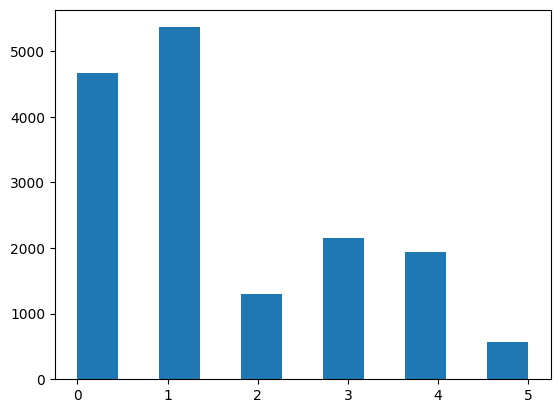

In [20]:
plt.hist(label, bins=11)
plt.show()

In [21]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
    ]
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
valTweet, valLabel = get_tweets(validation)
valTweet1 = get_seq(tokenizer, valTweet)
# valTweet


In [37]:
import numpy as np

# Convert labels to NumPy arrays
label = np.array(label)
valLabel = np.array(valLabel)


In [38]:
history = model.fit(
    padded, label,
    validation_data = (valTweet1, valLabel),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 20s 32ms/step - loss: 1.3301 - accuracy: 0.4593 - val_loss: 0.8243 - val_accuracy: 0.7090
Epoch 2/20
500/500 [==============================] - 27s 55ms/step - loss: 0.5482 - accuracy: 0.7956 - val_loss: 0.5647 - val_accuracy: 0.8065
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3201 - accuracy: 0.8966 - val_loss: 0.4350 - val_accuracy: 0.8545
Epoch 4/20
500/500 [==============================] - 39s 78ms/step - loss: 0.2148 - accuracy: 0.9299 - val_loss: 0.4008 - val_accuracy: 0.8635
Epoch 5/20
500/500 [==============================] - 40s 81ms/step - loss: 0.1773 - accuracy: 0.9450 - val_loss: 0.4172 - val_accuracy: 0.8710
Epoch 6/20
500/500 [==============================] - 42s 85ms/step - loss: 0.1240 - accuracy: 0.9606 - val_loss: 0.3987 - val_accuracy: 0.8800
Epoch 7/20
500/500 [==============================] - 43s 86ms/step - loss: 0.0966 - accuracy: 0.9703 - val_loss: 0.3765 - val_accuracy:

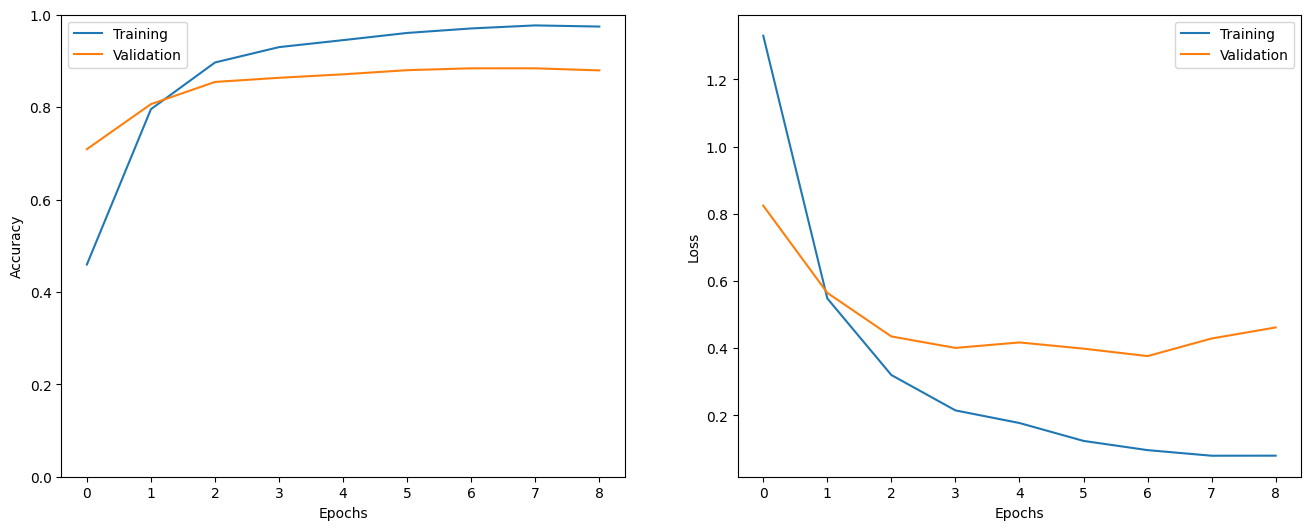

In [39]:
show_history(history)

In [43]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_seq(tokenizer, test_tweets)
import numpy as np

# Convert labels to NumPy arrays
test_labels = np.array(test_labels)


In [44]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 5ms/step - loss: 0.4473 - accuracy: 0.8780


[0.4473153054714203, 0.878000020980835]

In [58]:
i = random.randint(0, len(test_labels)-1)

print('Sentance', test_tweets[i])
print('Emotion', label[i])

p = model.predict(np.expand_dims(test_seq[i],axis=0))[0]
np.argmax(p).astype('uint8')

Sentance i feel like it might just be ok
Emotion 1
1/1 [==============================] - 0s 22ms/step


1

In [64]:
pred = model.predict(test_seq)
pred = np.argmax(pred,axis=-1)

63/63 [==============================] - 0s 6ms/step


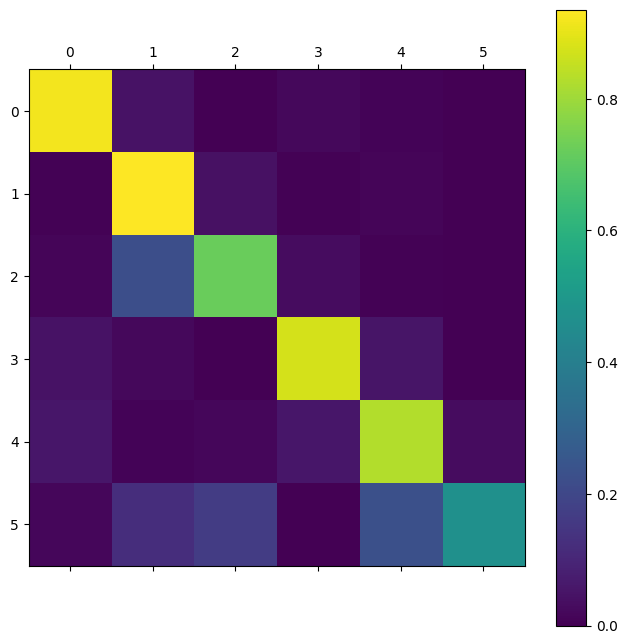

In [65]:
show_confusion_matrix(test_labels,pred,list(set(label)))